In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from datetime import datetime
import time
import joblib
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
# Display all dataframe columns
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.metrics import mean_squared_error

def rmse_precent(y_true, y_pred):
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # RMSE% rispetto alla media
    return (rmse / np.mean(y_true)) * 100

In [4]:
df = pd.read_csv("meleto_per_analisi.csv")
df.head(3)

,Treatment,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,UTC,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,UTC,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,UTC,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


In [5]:
print(df.apply(lambda col: col.unique()))

Treatment                                      [UTC, Brevis, BA, ACC]
target              [0.75, 0.33, 0.25, 0.5, 0.67, 1.0, 0.0, 0.4, 0...
botton_score        [0.043, 0.113, 0.0406, 0.0986, 0.0447, 0.1202,...
max                 [16.3, 17.3, 15.6, 16.4, 15.7, 15.8, 15.1, 13....
min                 [13.1, 12.2, 12.7, 9.0, 11.9, 11.0, 9.5, 7.5, ...
range               [3.2, 5.1, 2.9, 7.4, 3.8, 4.8, 7.8, 7.6, 4.9, ...
mean                [15.075, 14.7333, 14.2, 13.5, 13.3667, 13.6333...
std                 [1.3769, 2.5502, 1.3342, 3.3882, 2.0429, 2.433...
median              [15.45, 14.7, 14.25, 14.3, 12.5, 14.1, 16.7, 9...
non_zero_per_row                                [4, 3, 1, 5, 2, 6, 7]
dtype: object


In [6]:
# get treatment type for train_test_split stratify    
treatment = df['Treatment'] 

df = df.drop(columns=['Treatment',])
df.head(3)

,target,botton_score,max,min,range,mean,std,median,non_zero_per_row
0,0.75,0.0430,16.3,13.1,3.2,15.0750,1.3769,15.45,4
1,0.33,0.1130,17.3,12.2,5.1,14.7333,2.5502,14.70,3
2,0.25,0.0406,15.6,12.7,2.9,14.2000,1.3342,14.25,4


In [7]:
y = df['target'] 
X = df.drop(['target'], axis=1)

In [8]:
# 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=treatment)

In [9]:
# Remove botton score
X_train = X_train.drop(['botton_score'], axis=1)

# remove botton score
botton_score_test = X_test['botton_score']
X_test = X_test.drop(['botton_score'], axis=1)

# display for check
display(X_train.head(3))
display(X_test.head(3))

,max,min,range,mean,std,median,non_zero_per_row
5031,14.78,8.18,6.60,11.858,2.4517,12.140,5
10149,16.85,7.74,9.11,14.195,3.2803,15.185,6
7041,12.50,9.50,3.00,11.360,1.1524,11.400,5


,max,min,range,mean,std,median,non_zero_per_row
2880,13.60,10.06,3.54,11.4140,1.4248,11.440,5
4645,17.00,10.00,7.00,12.4000,2.8810,12.000,5
171,16.72,6.54,10.18,9.7425,4.7456,7.855,4


In [10]:
# Metrics for botton score for all sample no treatment
metrics_botton_score = {
    'Model': 'Botton score',
    'MAE': mean_absolute_error(y_test, botton_score_test), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, botton_score_test), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, botton_score_test), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, botton_score_test), # Root Mean Squared Error %    
    'R2': r2_score(y_test, botton_score_test), # R2
    'Median_AE': median_absolute_error(y_test, botton_score_test) # Median Absolute Error
}

## Random Forest Regression for all sample and no treatment as feature

In [11]:
# Define hyperparameter distribution for Random Forest
param_dist = {
    'n_estimators': randint(600, 1500), # integer
    'max_depth': randint(5, 8), # integer
    'min_samples_split': uniform(0.1, 0.5), # float
    'min_samples_leaf': uniform(0.01, 0.3), # float
    'max_features': uniform(0.1, 0.9), # float
    'min_weight_fraction_leaf': uniform(0.1, 0.4), # float
    'max_leaf_nodes': [2**n for n in range(1, 7)], # list of 2^n with $n \in N$
    'min_impurity_decrease': uniform(0.0, 1.0) # float
    #'bootstrap': [True, False]
}

In [12]:
# Define the model
model = RandomForestRegressor(criterion="squared_error", bootstrap=True, n_jobs=-1)

# Perform randomized search
rf_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=1000,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
    # random_state=42
)
    
# Fit the model 
rf_search.fit(X_train, y_train.squeeze())

# Miglior modello e predizioni
best_model = rf_search.best_estimator_ # BEST MODEL
y_pred = best_model.predict(X_test)

# Metrics
metrics = {
    'Model': 'Random Forest',
    'MAE': mean_absolute_error(y_test, y_pred), # Mean Absolute Error
    'MSE': mean_squared_error(y_test, y_pred), # Mean Squared Error
    'RMSE': root_mean_squared_error(y_test, y_pred), # Root Mean Squared Error
    'RMSE_per': rmse_precent(y_test, y_pred), # Root Mean Squared Error %    
    'R2': r2_score(y_test, y_pred), # R2
    'Median_AE': median_absolute_error(y_test, y_pred) # Median Absolute Error
}

# Save all
timestamp = datetime.now().strftime("%Y%m%dT%H%M") # Timestamp per i file
    
# (1) Save Best Model
joblib.dump(best_model, f"allsample_notreatment_RF_best_model_{timestamp}.pkl")
    
# (2) Save Metrics
df_metrics = pd.DataFrame([metrics_botton_score, metrics])  # una riga con tutte le metriche
df_metrics.to_csv(f"allsample_notreatment_RF_evaluation_metrics_{timestamp}.csv", index=False)
    
# (3) Save best hyper-parameters
best_params = rf_search.best_params_ # get best hyper-parameters
df_params = pd.DataFrame([best_params])  # una riga con tutti gli iperparametri
df_params.to_csv(f"allsample_notreatment_RF_best_params_{timestamp}.csv", index=False)
    
# (4) Save y_test e y_pred
df_pred = pd.DataFrame({'y_test': y_test.squeeze(), 'y_pred': y_pred})
df_pred.to_csv(f"allsample_notreatment_RF_predictions_{timestamp}.csv", index=False)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [13]:
print("Errors Botton score all sample and no treatment:")
print(f" - MAE: {round(metrics_botton_score['MAE'], 4)}")
print(f" - MSE: {round(metrics_botton_score['MSE'], 4)}")
print(f" - RMSE: {round(metrics_botton_score['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics_botton_score['RMSE_per'], 4)}")
print(f" - R2: {round(metrics_botton_score['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics_botton_score['Median_AE'], 4)}")

Errors Botton score all sample and no treatment:
 - MAE: 0.492
 - MSE: 0.3323
 - RMSE: 0.5764
 - RMSE_per: 89.6188
 - R2: -2.1648
 - Median Absolute Error: 0.4867


In [14]:
print("Errors Random Forest all sample and no treatment:")
print(f" - MAE: {round(metrics['MAE'], 4)}")
print(f" - MSE: {round(metrics['MSE'], 4)}")
print(f" - RMSE: {round(metrics['RMSE'], 4)}")
print(f" - RMSE_per: {round(metrics['RMSE_per'], 4)}")
print(f" - R2: {round(metrics['R2'], 4)}")
print(f" - Median Absolute Error: {round(metrics['Median_AE'], 4)}")

Errors Random Forest all sample and no treatment:
 - MAE: 0.2495
 - MSE: 0.0907
 - RMSE: 0.3012
 - RMSE_per: 46.8317
 - R2: 0.1358
 - Median Absolute Error: 0.2498


In [16]:
importances = best_model.feature_importances_

feat_importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# print("Migliori iperparametri:", rf_search.best_params_)
print("\nFeature importance:\n", feat_importances)


Feature importance:
             Feature  Importance
1               min    0.641641
3              mean    0.211081
5            median    0.116651
2             range    0.014953
0               max    0.013033
4               std    0.002641
6  non_zero_per_row    0.000000


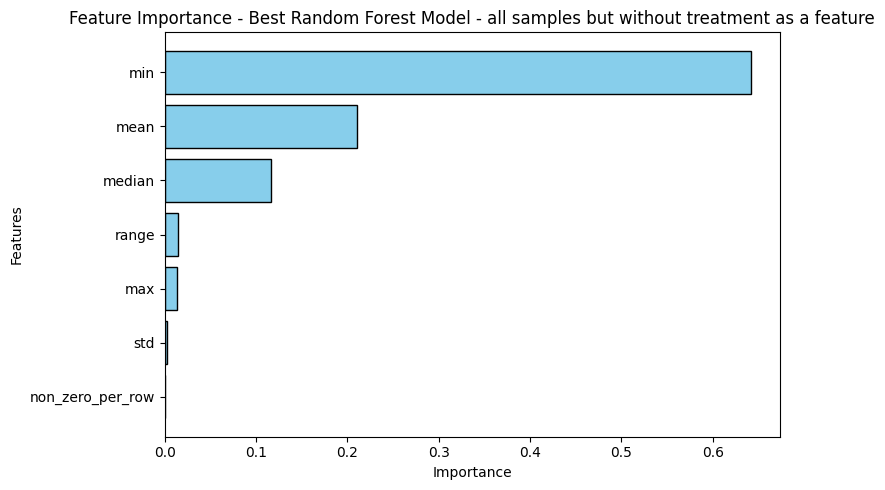

In [17]:
plt.figure(figsize=(8,5))
plt.barh(feat_importances["Feature"], feat_importances["Importance"], color="skyblue", edgecolor="black")
plt.title("Feature Importance - Best Random Forest Model - all samples but without treatment as a feature")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Per avere la più importante in alto
plt.tight_layout()
plt.show()